In [2]:
!rm -rf pokemon-recognition
!rm -rf dataset*
!git clone https://github.com/mattx7/pokemon-recognition
!mv pokemon-recognition/dataset .
!ls -lsh

Cloning into 'pokemon-recognition'...


remote: Counting objects: 1103, done.
remote: Compressing objects: 100% (5/5), done.


In [ ]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python

Requirement already up-to-date: pip in /usr/local/lib/python2.7/dist-packages (10.0.1)
  Running setup.py bdist_wheel for imutils ... - done
  Stored in directory: /content/.cache/pip/wheels/cb/58/9b/7debccbc53159611f67cc7e2e3ed37b217e56e9b40e7ba80c3
Successfully built imutils


In [1]:
import matplotlib

matplotlib.use("Agg")

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os
import imutils


/home/mattx7/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 2
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

DATASET_DIR = "dataset"
MODEL_FILE = "pokedex.model"
LABEL_BIN = "lb.pickle"
PLOT_FILE = "plot.png"
IMAGE_FILE = "examples/charmander_counter.png"

## PREPROCESS

In [5]:
# initialize the data and labels
data = []
labels = []

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
image_paths = sorted(list(paths.list_images(DATASET_DIR)))
random.seed(42)
random.shuffle(image_paths)

# loop over the input images
for imagePath in image_paths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

[INFO] loading images...
[INFO] data matrix: 0.00MB


ValueError: y has 0 samples: array([], dtype=float64)

partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [0]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode="nearest")

## MODEL

In [38]:
print("[INFO] compiling model...")
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()
width = IMAGE_DIMS[1]
height = IMAGE_DIMS[0]
depth = IMAGE_DIMS[2]
classes = len(lb.classes_)
inputShape = (height, width, depth)
chanDim = -1

# if we are using "channels first", update the input shape
# and channels dimension
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS),
              metrics=["accuracy"])

[INFO] compiling model...


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_288 (Conv2D)          (None, 96, 96, 32)        896       
_________________________________________________________________
activation_290 (Activation)  (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_289 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_291 (Activation)  (None, 32, 32, 64)        0         
__________

## TRAINING

In [40]:
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) // BS,
                        epochs=EPOCHS,
                        verbose=1)

[INFO] training network...
Epoch 1/300
29/29 [==============================] - 8s 278ms/step - loss: 1.4363 - acc: 0.6082 - val_loss: 1.0817 - val_acc: 0.7735
Epoch 2/300
29/29 [==============================] - 3s 100ms/step - loss: 0.7243 - acc: 0.7940 - val_loss: 0.7950 - val_acc: 0.8333
Epoch 3/300
29/29 [==============================] - 3s 103ms/step - loss: 0.7605 - acc: 0.7786 - val_loss: 1.0488 - val_acc: 0.8248
Epoch 4/300
29/29 [==============================] - 3s 98ms/step - loss: 0.5669 - acc: 0.8393 - val_loss: 0.6138 - val_acc: 0.8419
Epoch 5/300
29/29 [==============================] - 3s 99ms/step - loss: 0.5314 - acc: 0.8351 - val_loss: 0.6968 - val_acc: 0.8162
Epoch 6/300
29/29 [==============================] - 3s 97ms/step - loss: 0.7215 - acc: 0.7929 - val_loss: 1.1276 - val_acc: 0.7436
Epoch 7/300
22/29 [=====================>........] - ETA: 0s - loss: 0.5426 - acc: 0.8324

29/29 [==============================] - 3s 100ms/step - loss: 0.5539 - acc: 0.8222 - val_loss: 0.7399 - val_acc: 0.8205
Epoch 8/300
29/29 [==============================] - 3s 99ms/step - loss: 0.5638 - acc: 0.8474 - val_loss: 0.7286 - val_acc: 0.8034
Epoch 9/300
29/29 [==============================] - 3s 99ms/step - loss: 0.5687 - acc: 0.8198 - val_loss: 1.9252 - val_acc: 0.5897
Epoch 10/300
29/29 [==============================] - 3s 98ms/step - loss: 0.5239 - acc: 0.8315 - val_loss: 1.4345 - val_acc: 0.6923
Epoch 11/300
29/29 [==============================] - 3s 98ms/step - loss: 0.6526 - acc: 0.8270 - val_loss: 0.6559 - val_acc: 0.8077
Epoch 12/300
29/29 [==============================] - 3s 101ms/step - loss: 0.4396 - acc: 0.8696 - val_loss: 0.4313 - val_acc: 0.8803
Epoch 13/300
29/29 [==============================] - 3s 99ms/step - loss: 0.3403 - acc: 0.8964 - val_loss: 0.4932 - val_acc: 0.9017
Epoch 14/300
 5/29 [====>.........................] - ETA: 1s - loss: 0.4020 - acc

29/29 [==============================] - 3s 102ms/step - loss: 0.4152 - acc: 0.8541 - val_loss: 0.4207 - val_acc: 0.8803
Epoch 15/300
29/29 [==============================] - 3s 100ms/step - loss: 0.4389 - acc: 0.8580 - val_loss: 0.4833 - val_acc: 0.8419
Epoch 16/300
29/29 [==============================] - 3s 95ms/step - loss: 0.3407 - acc: 0.8916 - val_loss: 0.2795 - val_acc: 0.9017
Epoch 17/300
29/29 [==============================] - 3s 102ms/step - loss: 0.3031 - acc: 0.9041 - val_loss: 1.2637 - val_acc: 0.7350
Epoch 18/300
29/29 [==============================] - 3s 100ms/step - loss: 0.3574 - acc: 0.8863 - val_loss: 0.7854 - val_acc: 0.7991
Epoch 19/300
29/29 [==============================] - 3s 98ms/step - loss: 0.3107 - acc: 0.8853 - val_loss: 0.5000 - val_acc: 0.8462
Epoch 20/300
29/29 [==============================] - 3s 103ms/step - loss: 0.3072 - acc: 0.9016 - val_loss: 0.5560 - val_acc: 0.8333
Epoch 21/300
 5/29 [====>.........................] - ETA: 1s - loss: 0.2248 

29/29 [==============================] - 3s 102ms/step - loss: 0.2032 - acc: 0.9321 - val_loss: 0.5484 - val_acc: 0.8504
Epoch 22/300
29/29 [==============================] - 3s 96ms/step - loss: 0.3687 - acc: 0.8833 - val_loss: 0.4299 - val_acc: 0.8675
Epoch 23/300
29/29 [==============================] - 3s 97ms/step - loss: 0.3192 - acc: 0.8927 - val_loss: 0.3975 - val_acc: 0.9103
Epoch 24/300
29/29 [==============================] - 3s 97ms/step - loss: 0.2407 - acc: 0.9045 - val_loss: 0.8290 - val_acc: 0.8291
Epoch 25/300
29/29 [==============================] - 3s 103ms/step - loss: 0.2594 - acc: 0.9224 - val_loss: 0.6299 - val_acc: 0.8419
Epoch 26/300
29/29 [==============================] - 3s 100ms/step - loss: 0.2706 - acc: 0.9105 - val_loss: 0.3597 - val_acc: 0.9274
Epoch 27/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2890 - acc: 0.9025 - val_loss: 0.2911 - val_acc: 0.8932
Epoch 28/300
 5/29 [====>.........................] - ETA: 1s - loss: 0.4319 - 

29/29 [==============================] - 3s 98ms/step - loss: 0.2924 - acc: 0.9113 - val_loss: 0.6009 - val_acc: 0.8077
Epoch 29/300
29/29 [==============================] - 3s 99ms/step - loss: 0.3652 - acc: 0.9016 - val_loss: 1.1508 - val_acc: 0.8034
Epoch 30/300
29/29 [==============================] - 3s 97ms/step - loss: 0.3358 - acc: 0.8971 - val_loss: 0.7555 - val_acc: 0.7991
Epoch 31/300
29/29 [==============================] - 3s 97ms/step - loss: 0.2507 - acc: 0.9051 - val_loss: 0.4049 - val_acc: 0.9017
Epoch 32/300
29/29 [==============================] - 3s 101ms/step - loss: 0.2330 - acc: 0.9186 - val_loss: 1.0020 - val_acc: 0.8034
Epoch 33/300
29/29 [==============================] - 3s 100ms/step - loss: 0.3000 - acc: 0.9199 - val_loss: 0.3014 - val_acc: 0.9017
Epoch 34/300
29/29 [==============================] - 3s 98ms/step - loss: 0.2032 - acc: 0.9374 - val_loss: 0.2868 - val_acc: 0.9145
Epoch 35/300
 4/29 [===>..........................] - ETA: 1s - loss: 0.2442 - a

29/29 [==============================] - 3s 100ms/step - loss: 0.2443 - acc: 0.9122 - val_loss: 0.5798 - val_acc: 0.8718
Epoch 36/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2714 - acc: 0.9116 - val_loss: 0.5605 - val_acc: 0.8761
Epoch 37/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1643 - acc: 0.9396 - val_loss: 0.3511 - val_acc: 0.9060
Epoch 38/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1732 - acc: 0.9350 - val_loss: 0.2630 - val_acc: 0.9359
Epoch 39/300
29/29 [==============================] - 3s 99ms/step - loss: 0.3150 - acc: 0.9253 - val_loss: 1.3205 - val_acc: 0.7265
Epoch 40/300
29/29 [==============================] - 3s 98ms/step - loss: 0.3862 - acc: 0.8938 - val_loss: 0.3917 - val_acc: 0.8632
Epoch 41/300
29/29 [==============================] - 3s 100ms/step - loss: 0.2154 - acc: 0.9235 - val_loss: 0.3196 - val_acc: 0.9017
Epoch 42/300
 3/29 [==>...........................] - ETA: 1s - loss: 0.0388 -

29/29 [==============================] - 3s 97ms/step - loss: 0.1547 - acc: 0.9439 - val_loss: 0.7314 - val_acc: 0.8120
Epoch 43/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1751 - acc: 0.9386 - val_loss: 0.4530 - val_acc: 0.8932
Epoch 44/300
29/29 [==============================] - 3s 95ms/step - loss: 0.3573 - acc: 0.8797 - val_loss: 1.5987 - val_acc: 0.6752
Epoch 45/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2607 - acc: 0.9191 - val_loss: 0.8621 - val_acc: 0.7949
Epoch 46/300
29/29 [==============================] - 3s 98ms/step - loss: 0.3168 - acc: 0.9035 - val_loss: 2.7130 - val_acc: 0.5513
Epoch 47/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2999 - acc: 0.9095 - val_loss: 1.9061 - val_acc: 0.6325
Epoch 48/300
29/29 [==============================] - 3s 96ms/step - loss: 0.4637 - acc: 0.8704 - val_loss: 1.1616 - val_acc: 0.7179
Epoch 49/300
 2/29 [=>............................] - ETA: 1s - loss: 0.3810 - ac

29/29 [==============================] - 3s 99ms/step - loss: 0.2788 - acc: 0.9041 - val_loss: 0.3203 - val_acc: 0.9060
Epoch 50/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2116 - acc: 0.9202 - val_loss: 0.3633 - val_acc: 0.9188
Epoch 51/300
29/29 [==============================] - 3s 98ms/step - loss: 0.2323 - acc: 0.9199 - val_loss: 0.6519 - val_acc: 0.8846
Epoch 52/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2074 - acc: 0.9286 - val_loss: 0.4729 - val_acc: 0.8590
Epoch 53/300
29/29 [==============================] - 3s 98ms/step - loss: 0.2124 - acc: 0.9318 - val_loss: 0.3989 - val_acc: 0.9017
Epoch 54/300
29/29 [==============================] - 3s 93ms/step - loss: 0.2157 - acc: 0.9285 - val_loss: 0.4589 - val_acc: 0.8761
Epoch 55/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1816 - acc: 0.9504 - val_loss: 0.2808 - val_acc: 0.9402
Epoch 56/300
 5/29 [====>.........................] - ETA: 1s - loss: 0.2348 - acc

29/29 [==============================] - 3s 103ms/step - loss: 0.1626 - acc: 0.9440 - val_loss: 0.3833 - val_acc: 0.8846
Epoch 57/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1405 - acc: 0.9383 - val_loss: 0.7337 - val_acc: 0.8291
Epoch 58/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1589 - acc: 0.9469 - val_loss: 0.2710 - val_acc: 0.9060
Epoch 59/300
29/29 [==============================] - 3s 111ms/step - loss: 0.2419 - acc: 0.9227 - val_loss: 0.3079 - val_acc: 0.9274
Epoch 60/300
29/29 [==============================] - 3s 94ms/step - loss: 0.3845 - acc: 0.8728 - val_loss: 0.8640 - val_acc: 0.8162
Epoch 61/300
29/29 [==============================] - 3s 97ms/step - loss: 0.2274 - acc: 0.9253 - val_loss: 0.8152 - val_acc: 0.8419
Epoch 62/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1960 - acc: 0.9343 - val_loss: 0.5335 - val_acc: 0.8803
Epoch 63/300
 4/29 [===>..........................] - ETA: 1s - loss: 0.8526 

29/29 [==============================] - 3s 100ms/step - loss: 0.3514 - acc: 0.9043 - val_loss: 0.6231 - val_acc: 0.8718
Epoch 64/300
29/29 [==============================] - 3s 103ms/step - loss: 0.2235 - acc: 0.9119 - val_loss: 0.4362 - val_acc: 0.9060
Epoch 65/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1708 - acc: 0.9329 - val_loss: 2.3897 - val_acc: 0.5385
Epoch 66/300
29/29 [==============================] - 3s 106ms/step - loss: 0.2533 - acc: 0.9199 - val_loss: 0.8157 - val_acc: 0.8162
Epoch 67/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2082 - acc: 0.9385 - val_loss: 0.3189 - val_acc: 0.8846
Epoch 68/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1634 - acc: 0.9471 - val_loss: 0.3305 - val_acc: 0.9060
Epoch 69/300
29/29 [==============================] - 3s 100ms/step - loss: 0.2322 - acc: 0.9275 - val_loss: 1.0544 - val_acc: 0.7735
Epoch 70/300
 4/29 [===>..........................] - ETA: 2s - loss: 0.184

29/29 [==============================] - 3s 101ms/step - loss: 0.1548 - acc: 0.9482 - val_loss: 0.4223 - val_acc: 0.8889
Epoch 71/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1745 - acc: 0.9480 - val_loss: 0.3366 - val_acc: 0.8974
Epoch 72/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1471 - acc: 0.9394 - val_loss: 0.3556 - val_acc: 0.9231
Epoch 73/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1789 - acc: 0.9350 - val_loss: 0.4635 - val_acc: 0.9060
Epoch 74/300
29/29 [==============================] - 3s 97ms/step - loss: 0.1799 - acc: 0.9426 - val_loss: 0.3471 - val_acc: 0.9103
Epoch 75/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1459 - acc: 0.9504 - val_loss: 0.3761 - val_acc: 0.9188
Epoch 76/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0956 - acc: 0.9698 - val_loss: 0.3549 - val_acc: 0.9231
Epoch 77/300
 3/29 [==>...........................] - ETA: 1s - loss: 0.1218 - 

29/29 [==============================] - 3s 101ms/step - loss: 0.1787 - acc: 0.9437 - val_loss: 0.4747 - val_acc: 0.9017
Epoch 78/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1864 - acc: 0.9337 - val_loss: 0.5034 - val_acc: 0.8761
Epoch 79/300
29/29 [==============================] - 3s 104ms/step - loss: 0.2285 - acc: 0.9286 - val_loss: 0.6598 - val_acc: 0.8718
Epoch 80/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1566 - acc: 0.9504 - val_loss: 0.5008 - val_acc: 0.9017
Epoch 81/300
29/29 [==============================] - 3s 109ms/step - loss: 0.1795 - acc: 0.9361 - val_loss: 0.2647 - val_acc: 0.9274
Epoch 82/300
29/29 [==============================] - 3s 109ms/step - loss: 0.1799 - acc: 0.9415 - val_loss: 0.5193 - val_acc: 0.8846
Epoch 83/300
29/29 [==============================] - 3s 113ms/step - loss: 0.1260 - acc: 0.9537 - val_loss: 0.7150 - val_acc: 0.8590
Epoch 84/300
 6/29 [=====>........................] - ETA: 1s - loss: 0.126

29/29 [==============================] - 3s 108ms/step - loss: 0.2131 - acc: 0.9421 - val_loss: 0.5616 - val_acc: 0.9017
Epoch 85/300
29/29 [==============================] - 3s 115ms/step - loss: 0.2042 - acc: 0.9289 - val_loss: 0.5275 - val_acc: 0.8889
Epoch 86/300
29/29 [==============================] - 3s 109ms/step - loss: 0.1731 - acc: 0.9437 - val_loss: 0.6269 - val_acc: 0.8718
Epoch 87/300
29/29 [==============================] - 3s 106ms/step - loss: 0.2472 - acc: 0.9210 - val_loss: 0.9974 - val_acc: 0.8462
Epoch 88/300
29/29 [==============================] - 3s 112ms/step - loss: 0.1412 - acc: 0.9546 - val_loss: 0.6320 - val_acc: 0.8846
Epoch 89/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1378 - acc: 0.9558 - val_loss: 0.3646 - val_acc: 0.9145
Epoch 90/300
29/29 [==============================] - 3s 103ms/step - loss: 0.2749 - acc: 0.9327 - val_loss: 0.4500 - val_acc: 0.9060
Epoch 91/300
 3/29 [==>...........................] - ETA: 2s - loss: 0.115

29/29 [==============================] - 3s 103ms/step - loss: 0.4038 - acc: 0.8927 - val_loss: 2.1062 - val_acc: 0.6838
Epoch 92/300
29/29 [==============================] - 3s 108ms/step - loss: 0.3111 - acc: 0.9035 - val_loss: 1.8954 - val_acc: 0.6368
Epoch 93/300
29/29 [==============================] - 3s 106ms/step - loss: 0.2627 - acc: 0.9154 - val_loss: 0.2242 - val_acc: 0.9316
Epoch 94/300
29/29 [==============================] - 3s 105ms/step - loss: 0.2028 - acc: 0.9275 - val_loss: 0.2216 - val_acc: 0.9231
Epoch 95/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1141 - acc: 0.9601 - val_loss: 0.3155 - val_acc: 0.9274
Epoch 96/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1525 - acc: 0.9525 - val_loss: 0.3805 - val_acc: 0.8761
Epoch 97/300
29/29 [==============================] - 3s 107ms/step - loss: 0.1384 - acc: 0.9547 - val_loss: 0.2846 - val_acc: 0.9274
Epoch 98/300
 5/29 [====>.........................] - ETA: 2s - loss: 0.253

29/29 [==============================] - 3s 106ms/step - loss: 0.3619 - acc: 0.8971 - val_loss: 2.4066 - val_acc: 0.6966
Epoch 99/300
29/29 [==============================] - 3s 108ms/step - loss: 0.2226 - acc: 0.9165 - val_loss: 0.7552 - val_acc: 0.8291
Epoch 100/300
29/29 [==============================] - 3s 109ms/step - loss: 0.2127 - acc: 0.9278 - val_loss: 1.2567 - val_acc: 0.8120
Epoch 101/300
29/29 [==============================] - 3s 103ms/step - loss: 0.3606 - acc: 0.9037 - val_loss: 1.2098 - val_acc: 0.8120
Epoch 102/300
29/29 [==============================] - 3s 109ms/step - loss: 0.2228 - acc: 0.9343 - val_loss: 0.5844 - val_acc: 0.8889
Epoch 103/300
29/29 [==============================] - 3s 107ms/step - loss: 0.3144 - acc: 0.9146 - val_loss: 0.5208 - val_acc: 0.8974
Epoch 104/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1903 - acc: 0.9331 - val_loss: 0.4248 - val_acc: 0.9017
Epoch 105/300
 2/29 [=>............................] - ETA: 1s - loss:

29/29 [==============================] - 3s 106ms/step - loss: 0.2501 - acc: 0.9350 - val_loss: 0.3113 - val_acc: 0.9188
Epoch 106/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1650 - acc: 0.9437 - val_loss: 0.5875 - val_acc: 0.8846
Epoch 107/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1939 - acc: 0.9277 - val_loss: 0.2991 - val_acc: 0.9188
Epoch 108/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1569 - acc: 0.9471 - val_loss: 0.3951 - val_acc: 0.9103
Epoch 109/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1136 - acc: 0.9523 - val_loss: 0.6452 - val_acc: 0.8547
Epoch 110/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1905 - acc: 0.9321 - val_loss: 0.2747 - val_acc: 0.9103
Epoch 111/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1736 - acc: 0.9458 - val_loss: 0.3248 - val_acc: 0.9231
Epoch 112/300
 1/29 [>.............................] - ETA: 1s - loss

29/29 [==============================] - 3s 105ms/step - loss: 0.1412 - acc: 0.9545 - val_loss: 0.3575 - val_acc: 0.9103
Epoch 113/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1337 - acc: 0.9512 - val_loss: 0.3244 - val_acc: 0.8932
Epoch 114/300
29/29 [==============================] - 3s 106ms/step - loss: 0.0914 - acc: 0.9633 - val_loss: 0.3134 - val_acc: 0.9060
Epoch 115/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1467 - acc: 0.9599 - val_loss: 0.7060 - val_acc: 0.8333
Epoch 116/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1743 - acc: 0.9515 - val_loss: 0.3330 - val_acc: 0.9145
Epoch 117/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1459 - acc: 0.9590 - val_loss: 0.4786 - val_acc: 0.8846
Epoch 118/300
29/29 [==============================] - 3s 107ms/step - loss: 0.1006 - acc: 0.9579 - val_loss: 0.2830 - val_acc: 0.9188
Epoch 119/300
 2/29 [=>............................] - ETA: 2s - loss

29/29 [==============================] - 3s 103ms/step - loss: 0.1854 - acc: 0.9394 - val_loss: 0.8228 - val_acc: 0.8462
Epoch 120/300
29/29 [==============================] - 3s 105ms/step - loss: 0.2333 - acc: 0.9458 - val_loss: 0.4540 - val_acc: 0.9060
Epoch 121/300
29/29 [==============================] - 3s 110ms/step - loss: 0.3178 - acc: 0.9035 - val_loss: 1.1492 - val_acc: 0.7735
Epoch 122/300
29/29 [==============================] - 3s 106ms/step - loss: 0.2276 - acc: 0.9275 - val_loss: 0.5929 - val_acc: 0.8590
Epoch 123/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1570 - acc: 0.9342 - val_loss: 0.4217 - val_acc: 0.9060
Epoch 124/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1928 - acc: 0.9448 - val_loss: 0.7504 - val_acc: 0.8291
Epoch 125/300
29/29 [==============================] - 3s 110ms/step - loss: 0.2288 - acc: 0.9262 - val_loss: 0.4523 - val_acc: 0.8632
Epoch 126/300
 4/29 [===>..........................] - ETA: 2s - loss

29/29 [==============================] - 3s 111ms/step - loss: 0.2123 - acc: 0.9256 - val_loss: 0.2942 - val_acc: 0.9145
Epoch 127/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1027 - acc: 0.9730 - val_loss: 0.2421 - val_acc: 0.9231
Epoch 128/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1745 - acc: 0.9391 - val_loss: 0.3467 - val_acc: 0.9231
Epoch 129/300
29/29 [==============================] - 3s 108ms/step - loss: 0.1288 - acc: 0.9601 - val_loss: 0.2518 - val_acc: 0.9402
Epoch 130/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1613 - acc: 0.9545 - val_loss: 0.4431 - val_acc: 0.9017
Epoch 131/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1806 - acc: 0.9397 - val_loss: 0.2650 - val_acc: 0.9487
Epoch 132/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1175 - acc: 0.9566 - val_loss: 0.4862 - val_acc: 0.9060
Epoch 133/300
 1/29 [>.............................] - ETA: 1s - loss

29/29 [==============================] - 3s 106ms/step - loss: 0.2101 - acc: 0.9378 - val_loss: 0.4441 - val_acc: 0.8932
Epoch 134/300
29/29 [==============================] - 3s 108ms/step - loss: 0.2595 - acc: 0.9370 - val_loss: 0.7844 - val_acc: 0.8462
Epoch 135/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1626 - acc: 0.9537 - val_loss: 0.4683 - val_acc: 0.8889
Epoch 136/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1808 - acc: 0.9391 - val_loss: 0.5448 - val_acc: 0.8889
Epoch 137/300
29/29 [==============================] - 3s 103ms/step - loss: 0.2018 - acc: 0.9407 - val_loss: 0.7894 - val_acc: 0.8419
Epoch 138/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1645 - acc: 0.9391 - val_loss: 0.4588 - val_acc: 0.8803
Epoch 139/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1457 - acc: 0.9558 - val_loss: 0.3176 - val_acc: 0.8932
Epoch 140/300
 2/29 [=>............................] - ETA: 1s - loss:

29/29 [==============================] - 3s 102ms/step - loss: 0.1979 - acc: 0.9327 - val_loss: 0.2913 - val_acc: 0.9060
Epoch 141/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1445 - acc: 0.9469 - val_loss: 0.7784 - val_acc: 0.8205
Epoch 142/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1068 - acc: 0.9655 - val_loss: 0.2225 - val_acc: 0.9487
Epoch 143/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1110 - acc: 0.9555 - val_loss: 0.3114 - val_acc: 0.9188
Epoch 144/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2064 - acc: 0.9281 - val_loss: 0.3290 - val_acc: 0.9231
Epoch 145/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1767 - acc: 0.9424 - val_loss: 0.4214 - val_acc: 0.8974
Epoch 146/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2612 - acc: 0.9143 - val_loss: 1.1872 - val_acc: 0.7692
Epoch 147/300
 4/29 [===>..........................] - ETA: 1s - loss:

29/29 [==============================] - 3s 102ms/step - loss: 0.1221 - acc: 0.9558 - val_loss: 0.7473 - val_acc: 0.8632
Epoch 148/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1557 - acc: 0.9482 - val_loss: 0.7985 - val_acc: 0.8205
Epoch 149/300
29/29 [==============================] - 3s 99ms/step - loss: 0.0962 - acc: 0.9655 - val_loss: 0.3680 - val_acc: 0.9145
Epoch 150/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1381 - acc: 0.9566 - val_loss: 1.4068 - val_acc: 0.7479
Epoch 151/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1456 - acc: 0.9434 - val_loss: 0.4182 - val_acc: 0.8675
Epoch 152/300
29/29 [==============================] - 3s 104ms/step - loss: 0.2280 - acc: 0.9251 - val_loss: 0.4157 - val_acc: 0.9145
Epoch 153/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1549 - acc: 0.9501 - val_loss: 0.3955 - val_acc: 0.8974
Epoch 154/300
 2/29 [=>............................] - ETA: 1s - loss: 0

29/29 [==============================] - 3s 103ms/step - loss: 0.1203 - acc: 0.9591 - val_loss: 0.2756 - val_acc: 0.9444
Epoch 155/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1539 - acc: 0.9512 - val_loss: 0.7001 - val_acc: 0.8590
Epoch 156/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1941 - acc: 0.9385 - val_loss: 0.6107 - val_acc: 0.8675
Epoch 157/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1387 - acc: 0.9580 - val_loss: 0.3197 - val_acc: 0.9274
Epoch 158/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1052 - acc: 0.9644 - val_loss: 0.2241 - val_acc: 0.9359
Epoch 159/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1021 - acc: 0.9588 - val_loss: 0.4264 - val_acc: 0.8590
Epoch 160/300
29/29 [==============================] - 3s 110ms/step - loss: 0.1144 - acc: 0.9547 - val_loss: 0.3237 - val_acc: 0.9145
Epoch 161/300
 2/29 [=>............................] - ETA: 1s - loss: 

29/29 [==============================] - 3s 96ms/step - loss: 0.0956 - acc: 0.9666 - val_loss: 0.2876 - val_acc: 0.9402
Epoch 162/300
29/29 [==============================] - 3s 97ms/step - loss: 0.1260 - acc: 0.9564 - val_loss: 0.3920 - val_acc: 0.9274
Epoch 163/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1120 - acc: 0.9622 - val_loss: 0.5523 - val_acc: 0.9103
Epoch 164/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0863 - acc: 0.9676 - val_loss: 0.3777 - val_acc: 0.9316
Epoch 165/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0760 - acc: 0.9720 - val_loss: 0.3516 - val_acc: 0.9188
Epoch 166/300
29/29 [==============================] - 3s 99ms/step - loss: 0.0787 - acc: 0.9666 - val_loss: 0.2934 - val_acc: 0.9359
Epoch 167/300
29/29 [==============================] - 3s 97ms/step - loss: 0.0588 - acc: 0.9784 - val_loss: 0.3106 - val_acc: 0.9402


Epoch 168/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1395 - acc: 0.9642 - val_loss: 0.3167 - val_acc: 0.9274
Epoch 169/300
29/29 [==============================] - 3s 100ms/step - loss: 0.2012 - acc: 0.9230 - val_loss: 1.9377 - val_acc: 0.7308
Epoch 170/300
29/29 [==============================] - 3s 97ms/step - loss: 0.2288 - acc: 0.9286 - val_loss: 3.8423 - val_acc: 0.5470
Epoch 171/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2978 - acc: 0.9025 - val_loss: 0.6252 - val_acc: 0.8547
Epoch 172/300
29/29 [==============================] - 3s 98ms/step - loss: 0.2410 - acc: 0.9098 - val_loss: 0.4349 - val_acc: 0.8718
Epoch 173/300
29/29 [==============================] - 3s 93ms/step - loss: 0.1439 - acc: 0.9546 - val_loss: 0.3005 - val_acc: 0.9103
Epoch 174/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1070 - acc: 0.9666 - val_loss: 0.3697 - val_acc: 0.9103


Epoch 175/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1013 - acc: 0.9631 - val_loss: 1.1599 - val_acc: 0.8120
Epoch 176/300
29/29 [==============================] - 3s 101ms/step - loss: 0.3824 - acc: 0.8871 - val_loss: 0.8649 - val_acc: 0.7436
Epoch 177/300
29/29 [==============================] - 3s 102ms/step - loss: 0.3322 - acc: 0.8990 - val_loss: 0.5897 - val_acc: 0.8590
Epoch 178/300
29/29 [==============================] - 3s 95ms/step - loss: 0.1584 - acc: 0.9425 - val_loss: 0.4242 - val_acc: 0.8889
Epoch 179/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1110 - acc: 0.9655 - val_loss: 0.4515 - val_acc: 0.8846
Epoch 180/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1420 - acc: 0.9501 - val_loss: 1.0975 - val_acc: 0.8120
Epoch 181/300
29/29 [==============================] - 3s 95ms/step - loss: 0.1801 - acc: 0.9445 - val_loss: 1.3279 - val_acc: 0.7692
Epoch 182/300
 1/29 [>.............................] - ETA: 

29/29 [==============================] - 3s 100ms/step - loss: 0.1327 - acc: 0.9493 - val_loss: 0.4868 - val_acc: 0.9017
Epoch 183/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1298 - acc: 0.9545 - val_loss: 0.2976 - val_acc: 0.9402
Epoch 184/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0906 - acc: 0.9622 - val_loss: 0.2655 - val_acc: 0.9316
Epoch 185/300
29/29 [==============================] - 3s 96ms/step - loss: 0.0947 - acc: 0.9674 - val_loss: 0.2764 - val_acc: 0.9444
Epoch 186/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1297 - acc: 0.9609 - val_loss: 0.4207 - val_acc: 0.9017
Epoch 187/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1505 - acc: 0.9525 - val_loss: 0.5764 - val_acc: 0.8889
Epoch 188/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1137 - acc: 0.9601 - val_loss: 0.3325 - val_acc: 0.9188
Epoch 189/300
 3/29 [==>...........................] - ETA: 1s - loss: 0.

29/29 [==============================] - 3s 96ms/step - loss: 0.1785 - acc: 0.9421 - val_loss: 0.7252 - val_acc: 0.8974
Epoch 190/300
29/29 [==============================] - 3s 97ms/step - loss: 0.1120 - acc: 0.9555 - val_loss: 0.4144 - val_acc: 0.8974
Epoch 191/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0834 - acc: 0.9698 - val_loss: 0.3645 - val_acc: 0.9231
Epoch 192/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1252 - acc: 0.9577 - val_loss: 0.2314 - val_acc: 0.9359
Epoch 193/300
29/29 [==============================] - 3s 96ms/step - loss: 0.2370 - acc: 0.9345 - val_loss: 0.7472 - val_acc: 0.7863
Epoch 194/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1661 - acc: 0.9491 - val_loss: 0.4296 - val_acc: 0.9231
Epoch 195/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1029 - acc: 0.9720 - val_loss: 0.5027 - val_acc: 0.9145
Epoch 196/300
 3/29 [==>...........................] - ETA: 1s - loss: 0.173

29/29 [==============================] - 3s 98ms/step - loss: 0.2495 - acc: 0.9000 - val_loss: 1.2521 - val_acc: 0.7906
Epoch 197/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1592 - acc: 0.9407 - val_loss: 0.5980 - val_acc: 0.8718
Epoch 198/300
29/29 [==============================] - 3s 100ms/step - loss: 0.3271 - acc: 0.8911 - val_loss: 0.8040 - val_acc: 0.8889
Epoch 199/300
29/29 [==============================] - 3s 100ms/step - loss: 0.3372 - acc: 0.9018 - val_loss: 0.6465 - val_acc: 0.8889
Epoch 200/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1658 - acc: 0.9472 - val_loss: 0.3498 - val_acc: 0.9103
Epoch 201/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1326 - acc: 0.9600 - val_loss: 0.3745 - val_acc: 0.9103
Epoch 202/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1216 - acc: 0.9580 - val_loss: 0.2993 - val_acc: 0.9444


Epoch 203/300
29/29 [==============================] - 3s 96ms/step - loss: 0.0947 - acc: 0.9687 - val_loss: 0.4127 - val_acc: 0.8974
Epoch 204/300
29/29 [==============================] - 3s 96ms/step - loss: 0.0753 - acc: 0.9752 - val_loss: 0.2942 - val_acc: 0.9274
Epoch 205/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1413 - acc: 0.9596 - val_loss: 1.2399 - val_acc: 0.7393
Epoch 206/300
29/29 [==============================] - 3s 96ms/step - loss: 0.1879 - acc: 0.9372 - val_loss: 0.7909 - val_acc: 0.8034
Epoch 207/300
29/29 [==============================] - 3s 97ms/step - loss: 0.1237 - acc: 0.9558 - val_loss: 0.3168 - val_acc: 0.9274
Epoch 208/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1118 - acc: 0.9633 - val_loss: 0.3439 - val_acc: 0.9103
Epoch 209/300
29/29 [==============================] - 3s 95ms/step - loss: 0.0751 - acc: 0.9730 - val_loss: 0.3694 - val_acc: 0.9188
Epoch 210/300
 2/29 [=>............................] - ETA: 1s

29/29 [==============================] - 3s 95ms/step - loss: 0.0830 - acc: 0.9752 - val_loss: 0.3385 - val_acc: 0.9231
Epoch 211/300
29/29 [==============================] - 3s 93ms/step - loss: 0.1103 - acc: 0.9622 - val_loss: 0.3075 - val_acc: 0.9359
Epoch 212/300
29/29 [==============================] - 3s 100ms/step - loss: 0.0652 - acc: 0.9774 - val_loss: 0.3710 - val_acc: 0.9402
Epoch 213/300
29/29 [==============================] - 3s 97ms/step - loss: 0.1435 - acc: 0.9499 - val_loss: 0.4215 - val_acc: 0.9188
Epoch 214/300
29/29 [==============================] - 3s 97ms/step - loss: 0.2271 - acc: 0.9283 - val_loss: 0.8881 - val_acc: 0.7949
Epoch 215/300
29/29 [==============================] - 3s 95ms/step - loss: 0.1558 - acc: 0.9545 - val_loss: 0.4566 - val_acc: 0.9188
Epoch 216/300
29/29 [==============================] - 3s 95ms/step - loss: 0.1199 - acc: 0.9633 - val_loss: 0.3859 - val_acc: 0.9487
Epoch 217/300
 4/29 [===>..........................] - ETA: 1s - loss: 0.06

29/29 [==============================] - 3s 95ms/step - loss: 0.1265 - acc: 0.9609 - val_loss: 0.4851 - val_acc: 0.9103
Epoch 218/300
29/29 [==============================] - 3s 107ms/step - loss: 0.0855 - acc: 0.9674 - val_loss: 0.4296 - val_acc: 0.9316
Epoch 219/300
29/29 [==============================] - 3s 98ms/step - loss: 0.1282 - acc: 0.9590 - val_loss: 0.4505 - val_acc: 0.9359
Epoch 220/300
29/29 [==============================] - 3s 107ms/step - loss: 0.0925 - acc: 0.9655 - val_loss: 0.3713 - val_acc: 0.9231
Epoch 221/300
29/29 [==============================] - 3s 102ms/step - loss: 0.0893 - acc: 0.9642 - val_loss: 0.4001 - val_acc: 0.9274
Epoch 222/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0585 - acc: 0.9773 - val_loss: 0.2938 - val_acc: 0.9402
Epoch 223/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2200 - acc: 0.9483 - val_loss: 0.4017 - val_acc: 0.9145
Epoch 224/300
 1/29 [>.............................] - ETA: 1s - loss: 

29/29 [==============================] - 3s 107ms/step - loss: 0.1414 - acc: 0.9580 - val_loss: 0.4722 - val_acc: 0.9103
Epoch 225/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1041 - acc: 0.9574 - val_loss: 0.5560 - val_acc: 0.8718
Epoch 226/300
29/29 [==============================] - 3s 114ms/step - loss: 0.1199 - acc: 0.9601 - val_loss: 0.4182 - val_acc: 0.9145
Epoch 227/300
29/29 [==============================] - 3s 101ms/step - loss: 0.2086 - acc: 0.9545 - val_loss: 0.3939 - val_acc: 0.9188
Epoch 228/300
29/29 [==============================] - 3s 106ms/step - loss: 0.0572 - acc: 0.9817 - val_loss: 0.3008 - val_acc: 0.9487
Epoch 229/300
29/29 [==============================] - 3s 108ms/step - loss: 0.0688 - acc: 0.9741 - val_loss: 0.3134 - val_acc: 0.9444
Epoch 230/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0743 - acc: 0.9674 - val_loss: 0.2941 - val_acc: 0.9359
Epoch 231/300
 4/29 [===>..........................] - ETA: 2s - loss:

29/29 [==============================] - 3s 107ms/step - loss: 0.0558 - acc: 0.9784 - val_loss: 0.2321 - val_acc: 0.9615
Epoch 232/300
29/29 [==============================] - 3s 100ms/step - loss: 0.0936 - acc: 0.9663 - val_loss: 0.2209 - val_acc: 0.9444
Epoch 233/300
29/29 [==============================] - 3s 100ms/step - loss: 0.0517 - acc: 0.9795 - val_loss: 0.2545 - val_acc: 0.9402
Epoch 234/300
29/29 [==============================] - 3s 109ms/step - loss: 0.0587 - acc: 0.9752 - val_loss: 0.2742 - val_acc: 0.9444
Epoch 235/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0820 - acc: 0.9763 - val_loss: 0.3126 - val_acc: 0.9402
Epoch 236/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0642 - acc: 0.9752 - val_loss: 0.2998 - val_acc: 0.9530
Epoch 237/300
29/29 [==============================] - 3s 111ms/step - loss: 0.1382 - acc: 0.9594 - val_loss: 0.3001 - val_acc: 0.9274


Epoch 238/300
29/29 [==============================] - 3s 111ms/step - loss: 0.0901 - acc: 0.9609 - val_loss: 0.3869 - val_acc: 0.9274
Epoch 239/300
29/29 [==============================] - 3s 102ms/step - loss: 0.0615 - acc: 0.9774 - val_loss: 0.3749 - val_acc: 0.9316
Epoch 240/300
29/29 [==============================] - 3s 103ms/step - loss: 0.0926 - acc: 0.9706 - val_loss: 0.4149 - val_acc: 0.9316
Epoch 241/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1414 - acc: 0.9357 - val_loss: 0.4956 - val_acc: 0.8974
Epoch 242/300
29/29 [==============================] - 3s 102ms/step - loss: 0.0652 - acc: 0.9817 - val_loss: 0.3128 - val_acc: 0.9487
Epoch 243/300
29/29 [==============================] - 3s 107ms/step - loss: 0.0542 - acc: 0.9827 - val_loss: 0.2544 - val_acc: 0.9615
Epoch 244/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0662 - acc: 0.9795 - val_loss: 0.3182 - val_acc: 0.9487


Epoch 245/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1220 - acc: 0.9663 - val_loss: 0.5437 - val_acc: 0.8718
Epoch 246/300
29/29 [==============================] - 3s 105ms/step - loss: 0.0910 - acc: 0.9644 - val_loss: 0.5790 - val_acc: 0.9103
Epoch 247/300
29/29 [==============================] - 3s 106ms/step - loss: 0.0588 - acc: 0.9817 - val_loss: 0.3812 - val_acc: 0.9402
Epoch 248/300
29/29 [==============================] - 3s 100ms/step - loss: 0.0897 - acc: 0.9741 - val_loss: 0.2626 - val_acc: 0.9487
Epoch 249/300
29/29 [==============================] - 3s 103ms/step - loss: 0.0694 - acc: 0.9728 - val_loss: 0.3250 - val_acc: 0.9487
Epoch 250/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1210 - acc: 0.9577 - val_loss: 0.3550 - val_acc: 0.9359
Epoch 251/300
29/29 [==============================] - 3s 103ms/step - loss: 0.0879 - acc: 0.9676 - val_loss: 0.6769 - val_acc: 0.8932


Epoch 252/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1009 - acc: 0.9720 - val_loss: 0.3713 - val_acc: 0.9359
Epoch 253/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1258 - acc: 0.9674 - val_loss: 0.3767 - val_acc: 0.9402
Epoch 254/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1335 - acc: 0.9591 - val_loss: 0.4615 - val_acc: 0.8974
Epoch 255/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1488 - acc: 0.9456 - val_loss: 0.7510 - val_acc: 0.8932
Epoch 256/300
29/29 [==============================] - 3s 105ms/step - loss: 0.0939 - acc: 0.9623 - val_loss: 0.2971 - val_acc: 0.9487
Epoch 257/300
29/29 [==============================] - 3s 100ms/step - loss: 0.1081 - acc: 0.9655 - val_loss: 0.3341 - val_acc: 0.9316
Epoch 258/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0637 - acc: 0.9763 - val_loss: 0.2918 - val_acc: 0.9359
Epoch 259/300
 1/29 [>.............................] - E

29/29 [==============================] - 3s 103ms/step - loss: 0.0422 - acc: 0.9860 - val_loss: 0.3310 - val_acc: 0.9487
Epoch 260/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1030 - acc: 0.9663 - val_loss: 0.7152 - val_acc: 0.8504
Epoch 261/300
29/29 [==============================] - 3s 105ms/step - loss: 0.0880 - acc: 0.9698 - val_loss: 0.3632 - val_acc: 0.9316
Epoch 262/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1222 - acc: 0.9564 - val_loss: 0.4484 - val_acc: 0.9017
Epoch 263/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1763 - acc: 0.9491 - val_loss: 0.3624 - val_acc: 0.9402
Epoch 264/300
29/29 [==============================] - 3s 104ms/step - loss: 0.3867 - acc: 0.9111 - val_loss: 1.8129 - val_acc: 0.7436
Epoch 265/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1697 - acc: 0.9482 - val_loss: 0.8653 - val_acc: 0.8419
Epoch 266/300
 1/29 [>.............................] - ETA: 1s - loss

29/29 [==============================] - 3s 103ms/step - loss: 0.1359 - acc: 0.9622 - val_loss: 0.6318 - val_acc: 0.8846
Epoch 267/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1034 - acc: 0.9698 - val_loss: 0.8559 - val_acc: 0.8675
Epoch 268/300
29/29 [==============================] - 3s 102ms/step - loss: 0.2257 - acc: 0.9454 - val_loss: 0.2916 - val_acc: 0.9231
Epoch 269/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1484 - acc: 0.9525 - val_loss: 0.2362 - val_acc: 0.9530
Epoch 270/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1480 - acc: 0.9499 - val_loss: 0.8185 - val_acc: 0.7906
Epoch 271/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1181 - acc: 0.9577 - val_loss: 0.4041 - val_acc: 0.9103
Epoch 272/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1513 - acc: 0.9437 - val_loss: 0.7282 - val_acc: 0.8462


Epoch 273/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1360 - acc: 0.9588 - val_loss: 0.3381 - val_acc: 0.9188
Epoch 274/300
29/29 [==============================] - 3s 103ms/step - loss: 0.1008 - acc: 0.9676 - val_loss: 0.2390 - val_acc: 0.9573
Epoch 275/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1669 - acc: 0.9523 - val_loss: 0.4292 - val_acc: 0.8932
Epoch 276/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2267 - acc: 0.9478 - val_loss: 0.5126 - val_acc: 0.8974
Epoch 277/300
29/29 [==============================] - 3s 105ms/step - loss: 0.2201 - acc: 0.9300 - val_loss: 0.7782 - val_acc: 0.8376
Epoch 278/300
29/29 [==============================] - 3s 110ms/step - loss: 0.1186 - acc: 0.9577 - val_loss: 0.4540 - val_acc: 0.8932
Epoch 279/300
25/29 [========================>.....] - ETA: 0s - loss: 0.0942 - acc: 0.9700

29/29 [==============================] - 3s 101ms/step - loss: 0.0881 - acc: 0.9720 - val_loss: 0.3364 - val_acc: 0.9359
Epoch 280/300
29/29 [==============================] - 3s 102ms/step - loss: 0.0771 - acc: 0.9741 - val_loss: 0.2930 - val_acc: 0.9402
Epoch 281/300
29/29 [==============================] - 3s 99ms/step - loss: 0.1073 - acc: 0.9652 - val_loss: 0.4697 - val_acc: 0.9145
Epoch 282/300
29/29 [==============================] - 3s 104ms/step - loss: 0.1318 - acc: 0.9504 - val_loss: 0.4280 - val_acc: 0.9103
Epoch 283/300
29/29 [==============================] - 3s 99ms/step - loss: 0.2393 - acc: 0.9294 - val_loss: 1.5929 - val_acc: 0.7521
Epoch 284/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1734 - acc: 0.9482 - val_loss: 0.7484 - val_acc: 0.8718
Epoch 285/300
29/29 [==============================] - 3s 105ms/step - loss: 0.1051 - acc: 0.9688 - val_loss: 0.3835 - val_acc: 0.9103
Epoch 286/300
 1/29 [>.............................] - ETA: 1s - loss: 

29/29 [==============================] - 3s 101ms/step - loss: 0.1574 - acc: 0.9620 - val_loss: 0.2843 - val_acc: 0.9316
Epoch 287/300
29/29 [==============================] - 3s 101ms/step - loss: 0.0567 - acc: 0.9838 - val_loss: 0.3172 - val_acc: 0.9402
Epoch 288/300
29/29 [==============================] - 3s 98ms/step - loss: 0.0707 - acc: 0.9698 - val_loss: 0.2812 - val_acc: 0.9359
Epoch 289/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0650 - acc: 0.9763 - val_loss: 0.2849 - val_acc: 0.9530
Epoch 290/300
29/29 [==============================] - 3s 101ms/step - loss: 0.0624 - acc: 0.9784 - val_loss: 0.2960 - val_acc: 0.9316
Epoch 291/300
29/29 [==============================] - 3s 100ms/step - loss: 0.0932 - acc: 0.9687 - val_loss: 0.3044 - val_acc: 0.9402
Epoch 292/300
29/29 [==============================] - 3s 104ms/step - loss: 0.0722 - acc: 0.9720 - val_loss: 0.2802 - val_acc: 0.9444
Epoch 293/300
 1/29 [>.............................] - ETA: 1s - loss:

29/29 [==============================] - 3s 100ms/step - loss: 0.0650 - acc: 0.9773 - val_loss: 0.2473 - val_acc: 0.9402
Epoch 294/300
29/29 [==============================] - 3s 106ms/step - loss: 0.1363 - acc: 0.9488 - val_loss: 3.1404 - val_acc: 0.5513
Epoch 295/300
29/29 [==============================] - 3s 102ms/step - loss: 0.3521 - acc: 0.9073 - val_loss: 2.5599 - val_acc: 0.6624
Epoch 296/300
29/29 [==============================] - 3s 100ms/step - loss: 0.2443 - acc: 0.9216 - val_loss: 0.6927 - val_acc: 0.8333
Epoch 297/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1495 - acc: 0.9461 - val_loss: 0.6289 - val_acc: 0.8932
Epoch 298/300
29/29 [==============================] - 3s 102ms/step - loss: 0.1306 - acc: 0.9558 - val_loss: 0.5305 - val_acc: 0.8889
Epoch 299/300
29/29 [==============================] - 3s 101ms/step - loss: 0.1340 - acc: 0.9515 - val_loss: 0.5308 - val_acc: 0.8974
Epoch 300/300
 3/29 [==>...........................] - ETA: 1s - loss

29/29 [==============================] - 3s 103ms/step - loss: 0.1532 - acc: 0.9609 - val_loss: 0.4159 - val_acc: 0.9444


('Test loss:    ', 0.4158997577373794)
('Test accuracy:', 0.9444444444444444)
[INFO] serializing network...
[INFO] serializing label binarizer...


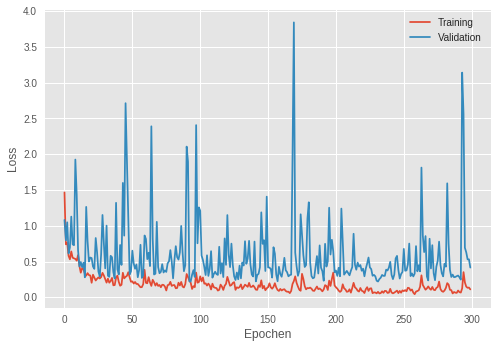

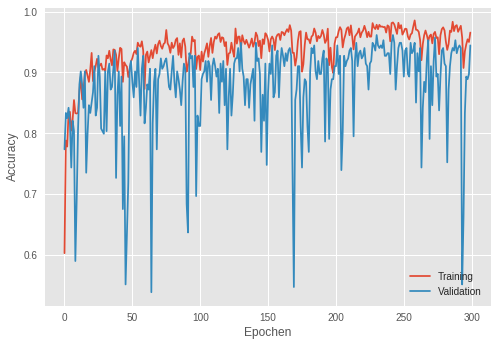

In [41]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

# save the model to disk
print("[INFO] serializing network...")
model.save(MODEL_FILE)

# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(LABEL_BIN, "wb")
f.write(pickle.dumps(lb))
f.close()

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")

plt.figure(0)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(np.arange(0, N), H.history['loss'])
plt.plot(np.arange(0, N), H.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(np.arange(0, N), H.history['acc'])
plt.plot(np.arange(0, N), H.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()


## ERROR ANALYSIS
1. show some wrong classified numbers
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [42]:
# predict test data 
predicted_classes = model.predict_classes(testX)

# find indices of correct an wrong classified numbers
correct   = np.nonzero(predicted_classes == testY)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != testY)[0]     #           elements that are non-zero

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """


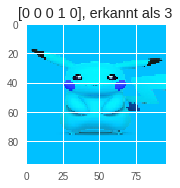

In [45]:
start                = 0    # Startindex

plt.figure(3)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(testX[incorr])
    plt.title("{}, erkannt als {}".format(testY[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [47]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(testY, predicted_classes))

ValueError: ignored

## CLASSIFIY

In [29]:
!ls -lh

total 100M
drwxr-xr-x 1 root root 4.0K May 21 17:02 datalab
drwxr-xr-x 7 root root 4.0K Jun 10 15:25 dataset
-rw-r--r-- 1 root root  571 Jun 10 15:32 lb.pickle
-rw-r--r-- 1 root root  43K Jun 10 15:32 plot.png
-rw-r--r-- 1 root root 100M Jun 10 15:32 pokedex.model
drwxr-xr-x 4 root root 4.0K Jun 10 15:26 pokemon-recognition


In [31]:
# load the image
#image = cv2.imread(IMAGE_FILE)
#output = image.copy()

# pre-process the image for classification
#image = cv2.resize(image, (96, 96))
#image = image.astype("float") / 255.0
#image = img_to_array(image)
#image = np.expand_dims(image, axis=0)

# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading network...")
model = load_model(MODEL_FILE)
lb = pickle.loads(open(LABEL_BIN, "rb").read())

# classify the input image
#print("[INFO] classifying image...")
#proba = model.predict(image)[0]
#idx = np.argmax(proba)
#label = lb.classes_[idx]

# we'll mark our prediction as "correct" of the input image filename
# contains the predicted label text (obviously this makes the
# assumption that you have named your testing image files this way)
filename = IMAGE_FILE[IMAGE_FILE.rfind(os.path.sep) + 1:]
correct = "correct" if filename.rfind(label) != -1 else "incorrect"

# build the label and draw the label on the image
label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
output = imutils.resize(output, width=400)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# show the output image
print("[INFO] {}".format(label))
cv2.imshow("Output", output)
cv2.waitKey(0)

[INFO] loading network...


NameError: ignored